In [276]:
!pip install yfinance
!pip install hmmlearn
!pip install matplotlib

In [277]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Data 1: Basket Data from yahoo

Data Collection and Preparation
Objective:
Step 1 seeks to collect financial time series data across a wide array of asset classes for 2019-2022. The data collected will be used in modeling regime changes using Markov-regime switching models. The activities at this step include identification of the appropriate data source, retrieval of the data, and preparation of such data for analysis.

Yahoo Finance:

Provides historical stock prices, index data, commodity prices, and currency exchange rates. You can use libraries such as yfinance to retrieve the data programmatically.

Website: https://finance.yahoo.com

In [278]:
# Download basket data from 2018 to 2024
tickers = ['BTC-USD', 'AAPL', '^VIX', '^GSPC'] # Bitcoin, Apple, Vix, S&P 500
df = pd.DataFrame()
for tick in tickers:
  data = yf.download(tick, start="2019-01-01", end="2022-12-31")
  df[tick] = data['Adj Close']

df.index = pd.to_datetime(df.index, format='%Y%m%d')


# Preview the first few rows
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC-USD,AAPL,^VIX,^GSPC
Date,,,,
2019-01-01,3843.520020,NaN,NaN,NaN
2019-01-02,3943.409424,37.750084,23.219999,2510.030029
2019-01-03,3836.741211,33.989899,25.450001,2447.889893
2019-01-04,3857.717529,35.440895,21.379999,2531.939941
2019-01-05,3845.194580,NaN,NaN,NaN
...,...,...,...,...
2022-12-26,16919.804688,NaN,NaN,NaN
2022-12-27,16717.173828,128.818436,21.650000,3829.250000
2022-12-28,16552.572266,124.865585,22.139999,3783.219971


 **Data Preparation**


Once you’ve collected the data, it is essential to clean and organize it for the analysis. Some steps include:



*   Handling missing values: Ensure that there are no gaps in the data, or fill missing values appropriately.
*   Calculate percentage change

In [279]:
# calculate daily returns
df.dropna(inplace=True)
df = df.pct_change(axis=0)
df.dropna(inplace=True)

## Step 2(a) - Plot the percentage change to visualize regimes

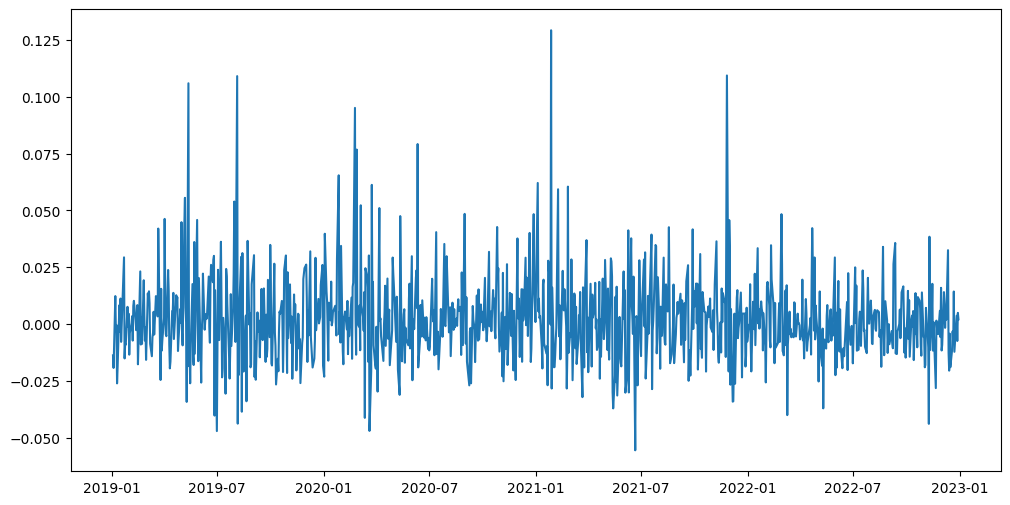

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df.mean(axis=1))
plt.show()

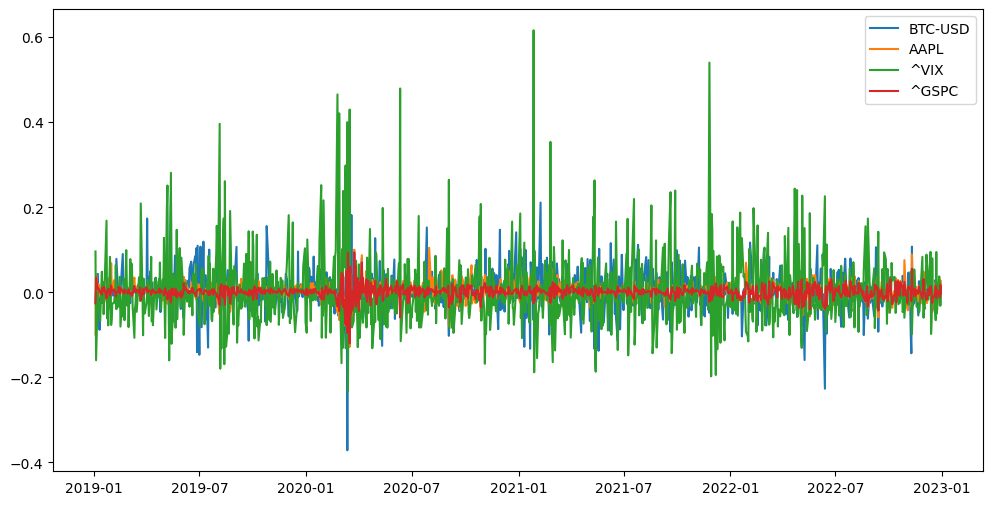

In [281]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df)
plt.legend(tickers)
plt.show()

## Correlation Matrix

In [282]:
df.corr()

,BTC-USD,AAPL,^VIX,^GSPC
BTC-USD,1.000000,0.252619,-0.251590,0.324448
AAPL,0.252619,1.000000,-0.572998,0.811273
^VIX,-0.251590,-0.572998,1.000000,-0.705823
^GSPC,0.324448,0.811273,-0.705823,1.000000


## Show Standard deviation

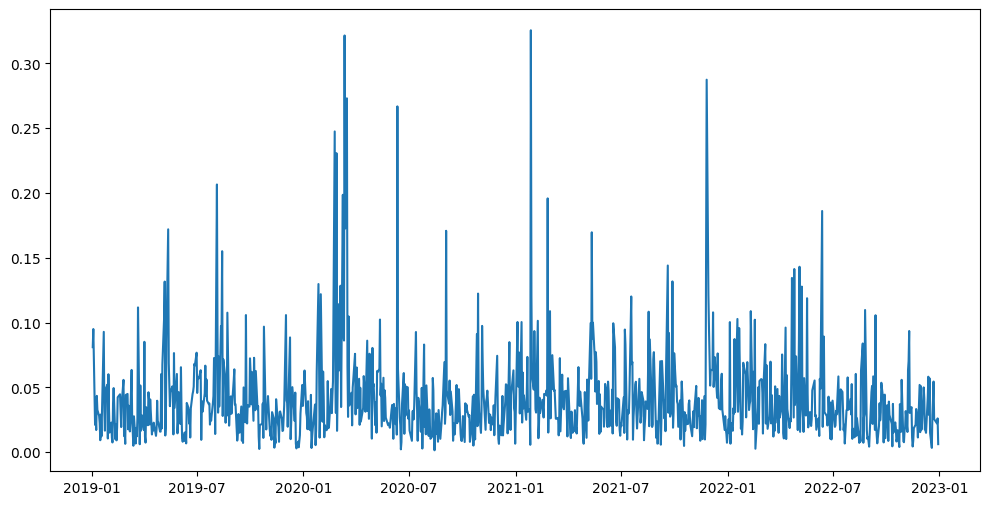

In [283]:
df = df.std(axis=1)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df)
plt.show()

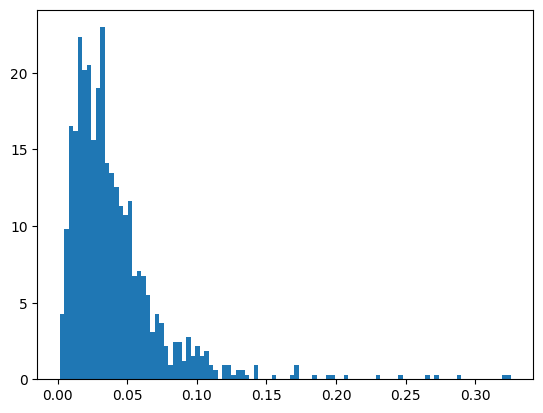

In [284]:
count, bins, ignored = plt.hist(df, 100, density=True)
plt.show()

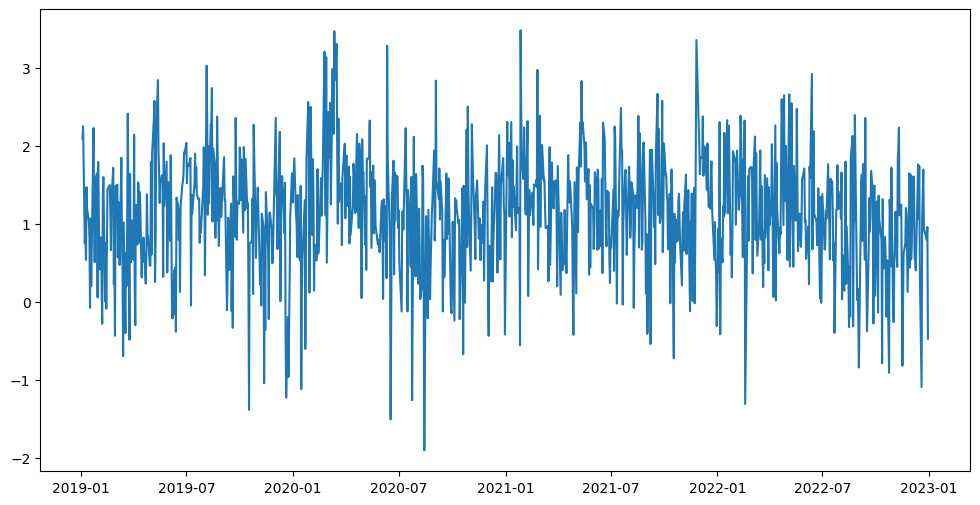

In [285]:
# log % returns
df = np.log(df * 100)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df)
plt.show()

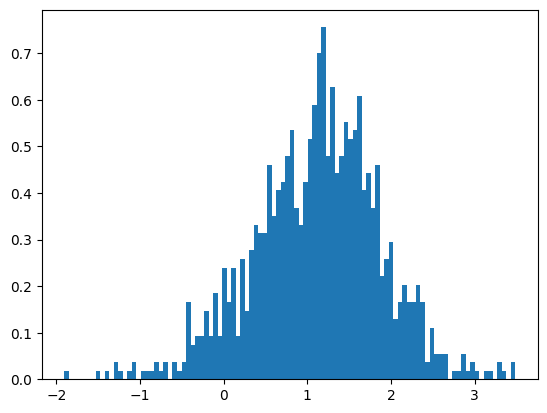

In [286]:
count, bins, ignored = plt.hist(df, 100, density=True)
plt.show()

##Step 2(b) - Estimate a Markov-regime switching model

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


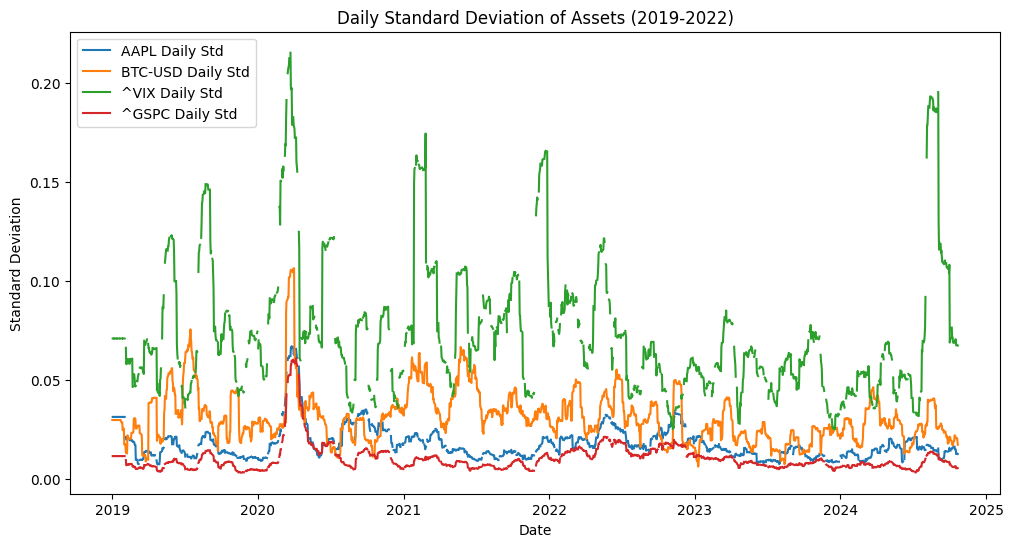

In [287]:
# Define the tickers for the assets we are analyzing
tickers = ['AAPL', 'BTC-USD', '^VIX', '^GSPC']  # Apple, Bitcoin, VIX, S&P 500

# Initialize an empty dictionary to store data for each asset
data_dict = {}

# Loop through each ticker and apply the same process
for ticker in tickers:
    # Step 1: Download data for each asset
    data = yf.download(ticker, start="2019-01-01", end="2024-12-31")

    # Step 2: Calculate daily returns
    data['Daily Returns'] = data['Adj Close'].pct_change()

    # Step 3: Calculate daily standard deviation with a 21-day rolling window
    data['Daily Std'] = data['Daily Returns'].rolling(window=21).std()

    # Step 4: Fill missing values to avoid broken lines
    data['Daily Std'].fillna(method='ffill', inplace=True)  # Forward fill the missing values
    data['Daily Std'].fillna(method='bfill', inplace=True)  # Backward fill as a fallback

    # Store the data in the dictionary
    data_dict[ticker] = data['Daily Std']

# Combine the datasets into a single DataFrame for plotting
df_combined = pd.DataFrame(data_dict)

# Step 5: Plot the daily standard deviation for each asset
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(df_combined.index, df_combined[ticker], label=f'{ticker} Daily Std')

plt.title('Daily Standard Deviation of Assets (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend(loc='upper left')
plt.show()


In [288]:
# Likelihood of an observation
def likelihood(xi_prob, mu, sigma, y):
    phi = norm.pdf((y - mu) / sigma) / sigma
    y_like = np.dot(xi_prob, phi)

    return y_like, phi

In [289]:
# Hamilton filtering
def forward_alg(pi_hat0, N, T, P, mu, sigma, Y):
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N))

    # Case t=1
    # Access the first row of the DataFrame using .iloc and select the first element
    y_like, phi = likelihood(pi_hat0, mu, sigma, Y.iloc[0, 0])  # Select the first column

    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T):
        # Access the rows of the DataFrame using .iloc and select the first element
        y_like, phi = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y.iloc[tt, 0]) # Select the first column

        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1

In [290]:
# Kim filtering
def backward_alg(xi_prob_t, xi_prob_t1, N, T, P):
    xi_prob_T = np.zeros((T, N))
    xi_prob_T[T - 1, :] = xi_prob_t[T - 1, :]

    for tt in range(T - 2, -1, -1):
        xi_T_xi = np.divide(xi_prob_T[tt + 1, :], xi_prob_t1[tt, :])
        for ss in range(0, N):
            xi_prob_T[tt, ss] = xi_prob_t[tt, ss] * np.dot(P[ss, :], xi_T_xi)

    return xi_prob_T  # , xi_prob_T1

In [291]:
def M_step_func(xi_prob, P, N, T, Y):  #
    mu_hat = np.zeros((N))
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )  # /np.sum(xi_prob[0:T-1,ss]) #np.sum(P[ss,:,1:T])
            # print( np.sum(xi_prob[0:T-1,ss]), np.sum(P[ss,:,1:T]))

        pi_hat[ss] = xi_prob[0, ss]

    return mu_hat, sigma_hat, P_hat, pi_hat

In [292]:
def log_likelihood2(xi_prob, T, pi_hat0, P, mu, sigma, Y):
  y_like = np.zeros(T)
  for tt in range(0, T):
    # Access data using .iloc to handle potential non-numeric index
    y_like[tt], _ = likelihood(xi_prob[tt, :], mu, sigma, Y.iloc[tt, 0])  # Assuming the relevant data is in the first column
  sum_log_like = np.sum(np.log(y_like))
  k = (np.prod(mu.shape)) + (np.prod(sigma.shape))
  k += (np.prod(pi_hat0.shape)) + (np.prod(P.shape))
  n = len(Y)
  akaike = 2 * k - 2 * sum_log_like
  schwarz = k * np.log(n) - 2 * sum_log_like
  return sum_log_like, akaike, schwarz

In [293]:
# Initialize parameters
T = len(df)
N = 2

# SET INITIAL GUESSES

mu_hat0 = [0, 2] * np.ones((N))
sigma_hat0 = [0.1, 0.1] * np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0[0, 0] = 0.75
P_hat0[0, 1] = 1 - P_hat0[0, 0]
P_hat0[1, 1] = 0.75
P_hat0[1, 0] = 1 - P_hat0[1, 1]

pi_hat0 = [0.5, 0.5] * np.ones((N))
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# Determine maximum number of iterations until convergence and convergence tolerance
itemax = 200
itetol = 1e-4
log_like0 = -1e8

for ite in range(0, itemax):
    print(mu_hat0, sigma_hat0, P_hat0, pi_hat0)

    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg(
        pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, df
    )
    xi_prob_T = backward_alg(
        xi_prob_t, xi_prob_t1, N, T, P_hat0
    )

    print("")
    plt.subplot(1, 2, 1)
    plt.plot(xi_prob_T[:, 0])
    plt.title("Estimated probability of state 0")
    plt.subplot(1, 2, 2)
    plt.plot(xi_prob_T[:, 1])
    plt.title("Estimated probability of state 1")
    fig = plt.gcf()
    fig.set_size_inches(16, 6)
    plt.show()
    print("")

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = (
                    P_hat0[ss, ss2]
                    * xi_prob_t[tt - 1, ss]
                    * xi_prob_T[tt, ss2]
                    / xi_prob_t1[tt - 1, ss2]
                )
    # check likelihood
    log_like1, akaike, schwarz = log_likelihood2(np.concatenate(([pi_hat0], xi_prob_t1[0:T-1])),
                                                T, pi_hat0, P_hat0, mu_hat0, sigma_hat0, df)
    diff = (log_like1 - log_like0)/abs(log_like0 + 1e-3)
    print(f"log_like0: {log_like0}")
    print(f"log_like1: {log_like1}")
    print("Iteration: ", ite)
    print("Log-Likelihoood: ", np.round(log_like1, 4), "Change: ", np.round(diff, 4))

    if diff > itetol:
      # M-Step
      mu_hat0, sigma_hat0, P_hat0, pi_hat0 = M_step_func(xi_prob_T, P_hat_T, N, T, df)
      log_like0 = log_like1
    else:
      print("final estimates")
      print("Log-Likelihood: ", np.round(log_like1, 4), "Akaike: ", np.round(akaike, 4), "Schwarz: ", np.round(schwarz, 4))
      print("mu: ", np.round(mu_hat0, 4))
      print("sigma: ", np.round(sigma_hat0, 4))
      print("Transition matrix: ")
      for ss in range(N):
        print(np.round(P_hat0[ss, :], 4))
      print("Initial probabilities: ", np.round(pi_hat0, 4))
      break



[0. 2.] [0.1 0.1] [[0.75 0.25]
 [0.25 0.75]] [0.5 0.5]


IndexingError: Too many indexers

In [ ]:
model = sm.tsa.MarkovRegression(df, k_regimes=2, switching_variance=True)
result = model.fit()
result.summary()

### (i) Models with different number of states N

In [ ]:
# Initialise parameters
T = len(df)
N = 4

# Initial guesses
mu_hat0 = [-0.1, 0, 0.5, 1]*np.ones((N))
sigma_hat0 = [0.1, 0.1, 0.1, 0.1]*np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0[0, 0] = 0.75
P_hat0[0, 1] = 0.15
P_hat0[0, 2] = 0.1
P_hat0[0, 3] = 0.0

P_hat0[1, 0] = 0.1
P_hat0[1, 1] = 0.75
P_hat0[1, 2] = 0.1
P_hat0[1, 3] = 0.05

P_hat0[2, 0] = 0.05
P_hat0[2, 1] = 0.1
P_hat0[2, 2] = 0.75
P_hat0[2, 3] = 0.1

P_hat0[3, 0] = 0
P_hat0[3, 1] = 0.1
P_hat0[3, 2] = 0.15
P_hat0[3, 3] = 0.75

pi_hat0 = [0.25, 0.25, 0.25, 0.25]*np.ones((N))
for t in range(1,100):
  pi_hat0 = np.dot(P_hat0.T, pi_hat0)

In [ ]:
def M_step_func_v2(xi_prob, P, N, T, Y):  #
    mu_hat = np.zeros((N))
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0,N):
        xi_y = np.dot(xi_prob[:,ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:,ss])

        xi_y_mu2 = np.dot(xi_prob[:,ss], (Y - mu_hat[ss])**2)
        sigma_hat += xi_y_mu2

        for ss2 in range(0,N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(P[ss, :, 1:])

        pi_hat[ss] = xi_prob[0,ss]

    sigma_hat = np.sqrt(sigma_hat/T)
    return mu_hat, sigma_hat, P_hat, pi_hat

In [ ]:
def M_step_func_v3(xi_prob, sigma_hat_prev, P_hat_T, N, T, Y):  # Changed P to P_hat_T to use the 3-dimensional array

    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    xi_y_sigma = np.zeros((N, T))
    xi_sigma = np.zeros((N))

    for ss in range(0,N):
      xi_y_sigma[ss] = np.dot(xi_prob[:,ss],Y)/sigma_hat_prev[ss]**2
      xi_sigma[ss] = np.sum(xi_prob[:,ss])/sigma_hat_prev[ss]**2
    mu_hat = np.sum(xi_y_sigma)/np.sum(xi_sigma)

    for ss in range(0,N):
      xi_y_mu2 = np.dot(xi_prob[:,ss], (Y - mu_hat)**2)
      sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss]))**0.5

      for ss2 in range(0,N):
        # Now using P_hat_T instead of P for the correct dimensionality
        P_hat[ss, ss2] = np.sum(P_hat_T[ss, ss2, 1:]) / np.sum(P_hat_T[ss, :, 1:])
      pi_hat[ss] = xi_prob[0,ss]

    return mu_hat, sigma_hat, P_hat, pi_hat

In [ ]:
# Determine maximum number of iterations until convergence and convergence tolerance
itemax = 200
itetol = 1e-4
log_like0 = -1e8

for ite in range(0, itemax):
    print(mu_hat0, sigma_hat0, P_hat0, pi_hat0)

    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg(
        pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, df
    )
    xi_prob_T = backward_alg(
        xi_prob_t, xi_prob_t1, N, T, P_hat0
    )

    print("")
    plt.subplot(1, 2, 1)
    plt.plot(xi_prob_T[:, 0])
    plt.title("Estimated probability of state 0")
    plt.subplot(1, 2, 2)
    plt.plot(xi_prob_T[:, 1])
    plt.title("Estimated probability of state 1")
    fig = plt.gcf()
    fig.set_size_inches(16, 6)
    plt.show()
    print("")

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = (
                    P_hat0[ss, ss2]
                    * xi_prob_t[tt - 1, ss]
                    * xi_prob_T[tt, ss2]
                    / xi_prob_t1[tt - 1, ss2]
                )
    # check likelihood
    log_like1, akaike, schwarz = log_likelihood2(np.concatenate(([pi_hat0], xi_prob_t1[0:T-1])),
                                                T, pi_hat0, P_hat0, mu_hat0, sigma_hat0, df)
    diff = (log_like1 - log_like0)/abs(log_like0 + 1e-3)
    print(f"log_like0: {log_like0}")
    print(f"log_like1: {log_like1}")
    print("Iteration: ", ite)
    print("Log-Likelihoood: ", np.round(log_like1, 4), "Change: ", np.round(diff, 4))

    if diff > itetol:
      # M-Step
      mu_hat0, sigma_hat0, P_hat0, pi_hat0 = M_step_func_v2(xi_prob_T, P_hat_T, N, T, df)
      log_like0 = log_like1
    else:
      print("final estimates")
      print("Log-Likelihood: ", np.round(log_like1, 4), "Akaike: ", np.round(akaike, 4), "Schwarz: ", np.round(schwarz, 4))
      print("mu: ", np.round(mu_hat0, 4))
      print("sigma: ", np.round(sigma_hat0, 4))
      print("Transition matrix: ")
      for ss in range(N):
        print(np.round(P_hat0[ss, :], 4))
      print("Initial probabilities: ", np.round(pi_hat0, 4))
      break

## (ii) Models with same "mu" different "sigma"

In [ ]:
# Initialise parameters
T = len(df)
N = 2

# Initial guesses
mu_hat0 = np.array([0.0, 0.0])
sigma_hat0 = np.array([0.1, 0.1])
P_hat0 = np.array([[0.97, 0.03], [0.03, 0.97]])
pi_hat0 = np.array([0.5, 0.5])

# Determine maximum number of iterations and convergence tolerance
itemax = 200
itetol = 1e-4
log_like0 = -1e8

for ite in range(0, itemax):
    print(mu_hat0, sigma_hat0, P_hat0, pi_hat0)

    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, df)
    xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T, P_hat0)

    # Plotting
    plt.subplot(1, 2, 1)
    plt.plot(xi_prob_T[:, 0])
    plt.title("Estimated probability of state 0")
    plt.subplot(1, 2, 2)
    plt.plot(xi_prob_T[:, 1])
    plt.title("Estimated probability of state 1")
    fig = plt.gcf()
    fig.set_size_inches(16, 6)
    plt.show()

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = (
                    P_hat0[ss, ss2]
                    * xi_prob_t[tt - 1, ss]
                    * xi_prob_T[tt, ss2]
                    / xi_prob_t1[tt - 1, ss2]
                )

    # Check likelihood
    log_like1, akaike, schwarz = log_likelihood2(
        np.concatenate((pi_hat0.reshape(1, -1), xi_prob_t1[0:T-1]), axis=0),
        T, pi_hat0, P_hat0, mu_hat0, sigma_hat0, df
    )

    diff = (log_like1 - log_like0) / abs(log_like0 + 1e-3)  # Add epsilon for numerical stability
    print(f"log_like0: {log_like0}")
    print(f"log_like1: {log_like1}")
    print("Iteration: ", ite)
    print("Log-Likelihood: ", np.round(log_like1, 4), "Change: ", np.round(diff, 4))

    if diff > itetol:
        # M-Step
        mu_hat0, sigma_hat0, P_hat0, pi_hat0 = M_step_func_v3(xi_prob_T, sigma_hat0, P_hat_T, N, T, df)
        log_like0 = log_like1
    else:
        print("Final estimates")
        print("Log-Likelihood: ", np.round(log_like1, 4), "Akaike: ", np.round(akaike, 4), "Schwarz: ", np.round(schwarz, 4))
        print("mu: ", np.round(mu_hat0, 4))
        print("sigma: ", np.round(sigma_hat0, 4))
        print("Transition matrix: ")
        for ss in range(N):
            print(np.round(P_hat0[ss, :], 4))
        print("Initial probabilities: ", np.round(pi_hat0, 4))
        break


## Hidden Markov with an AR(1) process

In [ ]:
def likelihood_AR1(xi_prob, mu, sigma, rho, y, y_1):
    # Ensure mu, sigma, and rho are NumPy arrays
    mu = np.array(mu)
    sigma = np.array(sigma)
    rho = np.array(rho)

    # Perform the calculation
    phi = norm.pdf((y - mu - rho * y_1) / sigma) / sigma
    y_like = np.dot(xi_prob, phi)
    return y_like, phi

In [ ]:
def backward_alg_AR1(xi_prob_t, xi_prob_t1, N, T, P):
    xi_prob_T = np.zeros((T, N))

    xi_prob_T[T - 1, :] = xi_prob_t1[T - 2, :]

    for tt in range(T - 2, -1, -1):
        for ss in range(0, N):
            xi_prob_aux = [
                P[ss, ss2] * xi_prob_T[tt + 1, ss2] for ss2 in range(0, N)
            ]
            # Calculate the dot product as the sum of element-wise multiplication
            xi_prob_T[tt, ss] = np.sum(xi_prob_t[tt, ss] * np.array(xi_prob_aux))

    return xi_prob_T

In [ ]:
# Hamilton filtering
def forward_alg_AR1(pi_hat0, N, T, P, mu, sigma, rho, Y):

    xi_prob_t = np.zeros((T-1, N))
    xi_prob_t1 = np.zeros((T-1, N))

    # Case t=1
    # Access data values using .iloc to avoid KeyError
    y_like, phi = likelihood_AR1(pi_hat0, mu, sigma, rho, Y.iloc[1, 0], Y.iloc[0, 0])

    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like

    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T-1):
        # Access data values using .iloc to avoid KeyError
        y_like, phi = likelihood_AR1(xi_prob_t1[tt-1, :], mu, sigma, rho, Y.iloc[tt+1, 0], Y.iloc[tt, 0])

        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt-1, :], phi) / y_like

        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1

In [ ]:
def M_step_func_AR1(xi_prob, P, N, T, Y):
  mu_hat = np.zeros((N))
  rho_hat = np.zeros((N))
  sigma_hat = np.zeros((N))
  P_hat = np.zeros((N, N))
  pi_hat = np.zeros((N))

  for ss in range(0,N):
    # Access data values using .iloc to avoid KeyError
    # Adjust the slicing of xi_prob to match the size of Y.iloc[1:, 0].values
    xi_y = np.sqrt(xi_prob[1:,ss])*Y.iloc[1:, 0].values # Assuming single column named '0' or adjust as needed
    z = np.stack((np.ones(T-1), Y.iloc[:-1, 0].values), axis=1) # Assuming single column named '0' or adjust as needed
    xi_z = np.zeros((T-1,N))
    # Adjust the slicing of xi_prob to match the size of z[:,0] and z[:,1]
    xi_z[:,0] = np.sqrt(xi_prob[1:,ss])*z[:,0]
    xi_z[:,1] = np.sqrt(xi_prob[1:,ss])*z[:,1]
    z_xi_z_inv = np.linalg.inv(np.dot(xi_z.T, xi_z))
    beta_hat = np.dot(z_xi_z_inv, np.dot(xi_z.T, xi_y))

    mu_hat[ss] = beta_hat[0]
    rho_hat[ss] = beta_hat[1]

    # Access data values using .iloc to avoid KeyError
    residuals = Y.iloc[1:, 0].values-np.dot(z, beta_hat) # Assuming single column named '0' or adjust as needed
    # Adjust the slicing of xi_prob to match the size of residuals**2
    xi_y_mu2 = np.dot(xi_prob[1:,ss], residuals**2)
    sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[1:, ss]))**0.5

    for ss2 in range(0,N):
      P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(P[ss, :, 1:])

    pi_hat[ss] = xi_prob[0,ss]

  return mu_hat, rho_hat, sigma_hat, P_hat, pi_hat

In [ ]:
def log_likelihood2_AR1(xi_prob, T, pi_hat0, P, mu, sigma, rho, Y):
  y_like = np.zeros(T-1)
  for tt in range(0, T-1):
    # Access data values using .iloc to avoid KeyError
    y_like[tt], _ = likelihood_AR1(xi_prob[tt, :], mu, sigma, rho, Y.iloc[tt+1, 0], Y.iloc[tt, 0])

  sum_log_like = np.sum(np.log(y_like))
  k = (np.prod(mu.shape)) + (np.prod(sigma.shape)) + (np.prod(rho.shape))
  k += (np.prod(pi_hat0.shape)) + (np.prod(P.shape))
  n = len(Y)-1
  akaike = 2 * k - 2 * sum_log_like
  schwarz = k * np.log(n) - 2 * sum_log_like
  return sum_log_like, akaike, schwarz

In [ ]:
# Initialise parameters
T = len(df)
N = 2

# Initial guesses
mu_hat0 = np.array([0.2329, 0.8364])
sigma_hat0 = np.array([0.2020, 0.2861])
P_hat0 = np.array([[0.9864, 0.0136],  # Final transition matrix
                   [0.0195, 0.9805]])

pi_hat0 = np.array([0.0, 1.0])

# Change rho_hat0 to a NumPy array
rho_hat0 = np.array([0.1, 0.1])

# Determine maximum number of iterations and convergence tolerance
itemax = 200
itetol = 1e-4
log_like0 = -1e8


for ite in range(0, itemax):
    print(mu_hat0, sigma_hat0, P_hat0, pi_hat0)

    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg_AR1(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, rho_hat0, df)
    xi_prob_T = backward_alg_AR1(xi_prob_t, xi_prob_t1, N, T, P_hat0)

    # Plotting
    plt.subplot(1, 2, 1)
    plt.plot(xi_prob_T[:, 0])
    plt.title("Estimated probability of state 0")
    plt.subplot(1, 2, 2)
    plt.plot(xi_prob_T[:, 1])
    plt.title("Estimated probability of state 1")
    fig = plt.gcf()
    fig.set_size_inches(16, 6)
    plt.show()

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T-1))
    for tt in range(1, T-1):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = (
                    P_hat0[ss, ss2]
                    * xi_prob_t[tt - 1, ss]
                    * xi_prob_T[tt, ss2]
                    / xi_prob_t1[tt - 1, ss2]
                )

    # Check likelihood
    log_like1, akaike, schwarz = log_likelihood2_AR1(
        np.concatenate(([pi_hat0], xi_prob_t1[0:T-2])),
        T, pi_hat0, P_hat0, mu_hat0, sigma_hat0, rho_hat0, df
    )

    diff = (log_like1 - log_like0) / abs(log_like0 + 1e-3)
    print(f"log_like0: {log_like0}")
    print(f"log_like1: {log_like1}")
    print("Iteration: ", ite)
    print("Log-Likelihood: ", np.round(log_like1, 4), "Change: ", np.round(diff, 4))

    if diff > itetol:
        # M-Step
        mu_hat0, rho_hat0, sigma_hat0, P_hat0, pi_hat0 = M_step_func_AR1(xi_prob_T, P_hat_T, N, T, df)
        log_like0 = log_like1
    else:
        print("Final estimates")
        print("Log-Likelihood: ", np.round(log_like1, 4), "Akaike: ", np.round(akaike, 4), "Schwarz: ", np.round(schwarz, 4))
        print("mu: ", np.round(mu_hat0, 4))
        print("sigma: ", np.round(sigma_hat0, 4))
        print("Transition matrix: ")
        for ss in range(N):
            print(np.round(P_hat0[ss, :], 4))
        print("Initial probabilities: ", np.round(pi_hat0, 4))
        break

In [ ]:
# Step 1: Download data for AAPL
aapl_data = yf.download('AAPL', start="2019-01-01", end="2024-10-01")

# Step 2: Calculate daily returns
aapl_data['Returns'] = aapl_data['Adj Close'].pct_change().dropna()

# Step 3: Fit the Markov Switching Autoregressive Model (MS-AR)
# Two-state model with regime-dependent mean and variance
model = MarkovRegression(aapl_data['Returns'], k_regimes=2, trend='c', switching_variance=True)
results = model.fit()

# Step 4: Extract the smoothed probabilities for each regime
smoothed_probs = results.smoothed_marginal_probabilities[0]

# Step 5: Plot the time series along with the smoothed regime probabilities
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual returns
ax.plot(aapl_data.index, aapl_data['Returns'], label='AAPL Returns', color='blue')

# Highlight low-volatility regime (State 1) in a different color
ax.fill_between(aapl_data.index, min(aapl_data['Returns']), max(aapl_data['Returns']),
                where=smoothed_probs > 0.5, color='red', alpha=0.3, label='State 1: Low Volatility')

# Highlight high-volatility regime (State 2) in a different color
ax.fill_between(aapl_data.index, min(aapl_data['Returns']), max(aapl_data['Returns']),
                where=smoothed_probs <= 0.5, color='green', alpha=0.3, label='State 2: High Volatility')

# Set titles and labels
ax.set_title('AAPL Returns with Markov Switching Regimes (Low and High Volatility)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Returns', fontsize=12)
ax.legend()

plt.show()
